In [1]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split

# Load ratings and movies
ratings = pd.read_csv("backend/data/ratings.csv")
movies = pd.read_csv("backend/data/movies.csv")

# Setup surprise
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2)




In [7]:
from surprise import Dataset, Reader, SVD, KNNBasic, SlopeOne, BaselineOnly, CoClustering
from surprise.model_selection import KFold
from surprise.accuracy import rmse, mae
from collections import defaultdict
import pandas as pd
import numpy as np

# Define models (lowercase keys, extended names)
models = {
    'svd': SVD(),
    'knn_user': KNNBasic(sim_options={"name": "cosine", "user_based": True}),
    'knn_item': KNNBasic(sim_options={"name": "cosine", "user_based": False}),
    'slope_one': SlopeOne(),
    'baseline': BaselineOnly(),
    'coclustering': CoClustering()
}

# Evaluation config
K = 5  # Top-K recommendations
threshold = 4.0  # "Relevant" rating threshold
n_splits = 5  # 5-fold cross-validation
results = []

# Top-N recommender utility
def get_top_n(predictions, k=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est, true_r))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:k]
    return top_n

# Precision@K and Recall@K calculator
def precision_recall_at_k(top_n, threshold=4.0):
    precisions, recalls = [], []
    for uid, user_ratings in top_n.items():
        n_rel = sum((true_r >= threshold) for (_, _, true_r) in user_ratings)
        n_rec = sum((est >= threshold) for (_, est, _) in user_ratings)
        n_rel_and_rec = sum((true_r >= threshold and est >= threshold) for (_, est, true_r) in user_ratings)

        precision = n_rel_and_rec / max(n_rec, 1)
        recall = n_rel_and_rec / max(n_rel, 1)

        precisions.append(precision)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)

# Run 5-fold cross-validation for each model
for name, model in models.items():
    print(f"\nEvaluating: {name}")

    kf = KFold(n_splits=n_splits)
    all_rmse, all_mae, all_precision, all_recall = [], [], [], []

    for trainset, testset in kf.split(data):
        model.fit(trainset)
        predictions = model.test(testset)

        # RMSE / MAE
        all_rmse.append(rmse(predictions, verbose=False))
        all_mae.append(mae(predictions, verbose=False))

        # Precision@K / Recall@K
        top_n = get_top_n(predictions, k=K)
        precision, recall = precision_recall_at_k(top_n, threshold=threshold)
        all_precision.append(precision)
        all_recall.append(recall)
        
    results.append({
        "Model": name,
        "Avg RMSE": np.mean(all_rmse),
        "Avg MAE": np.mean(all_mae),
        f"Precision@{K}": np.mean(all_precision),
        f"Recall@{K}": np.mean(all_recall)
    })

    # Print average metrics
    print(f"Avg RMSE       : {np.mean(all_rmse):.4f}")
    print(f"Avg MAE        : {np.mean(all_mae):.4f}")
    print(f"Avg Precision@{K}: {np.mean(all_precision):.4f}")
    print(f"Avg Recall@{K}   : {np.mean(all_recall):.4f}")



Evaluating: svd
Avg RMSE       : 0.8736
Avg MAE        : 0.6715
Avg Precision@5: 0.5899
Avg Recall@5   : 0.5727

Evaluating: knn_user
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Avg RMSE       : 0.9721
Avg MAE        : 0.7490
Avg Precision@5: 0.6590
Avg Recall@5   : 0.6772

Evaluating: knn_item
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing simila

/home/ronald/movie-lens-dataset/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Avg RMSE       : 0.9015
Avg MAE        : 0.6888
Avg Precision@5: 0.6147
Avg Recall@5   : 0.6371

Evaluating: baseline
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Avg RMSE       : 0.8720
Avg MAE        : 0.6723
Avg Precision@5: 0.5514
Avg Recall@5   : 0.5027

Evaluating: coclustering
Avg RMSE       : 0.9457
Avg MAE        : 0.7323
Avg Precision@5: 0.5804
Avg Recall@5   : 0.6142


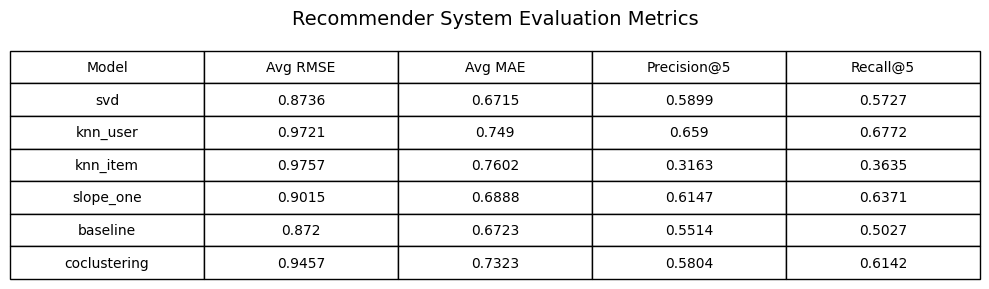

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df_results = pd.DataFrame(results)

# Round for clean display
df_results = df_results.round(4)

# Plot as table
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('off')
table = ax.table(cellText=df_results.values,
                 colLabels=df_results.columns,
                 cellLoc='center',
                 loc='center')
table.scale(1, 2)
plt.title("Recommender System Evaluation Metrics", fontsize=14, pad=20)
plt.tight_layout()
plt.show()
